In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
path = r"Nox/data/current.csv"
df = pd.read_csv(path, sep=';')

In [3]:
df.columns

Index(['Datetime', 'Resolution code', 'Quality status', 'ACE',
       'System imbalance', 'Alpha', 'Alpha'', 'Marginal incremental price',
       'Marginal decremental price', 'Imbalance Price'],
      dtype='object')

Set correct index and convert to datetime

In [4]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [5]:
df = df[['Imbalance Price']].copy()

In [6]:
df.describe()

,Imbalance Price
count,63.000000
mean,70.677683
std,42.914159
min,-149.883000
25%,54.625000
50%,77.150000
75%,80.000000
max,177.419000


In [7]:
df.head()

,Imbalance Price
Datetime,
2025-10-29 15:30:00+01:00,64.691
2025-10-29 15:15:00+01:00,98.147
2025-10-29 15:00:00+01:00,-149.883
2025-10-29 14:45:00+01:00,84.095
2025-10-29 14:30:00+01:00,126.867


In [8]:
df.isna().sum()

Imbalance Price    0
dtype: int64

No missing values

Let's drop all columns except the price_eur_mwh (index is already set to datetime_utc)

Let's fit a timeseries model.

Preprocessing - There are not missing values, let's detect outliers

In [9]:
df.loc[:, 'z_scores'] = np.abs(zscore(df['Imbalance Price']))

In [10]:
df['z_scores'] 

Datetime
2025-10-29 15:30:00+01:00    0.140624
2025-10-29 15:15:00+01:00    0.645241
2025-10-29 15:00:00+01:00    5.180861
2025-10-29 14:45:00+01:00    0.315166
2025-10-29 14:30:00+01:00    1.319859
                               ...   
2025-10-29 01:00:00+01:00    0.207232
2025-10-29 00:45:00+01:00    0.217097
2025-10-29 00:30:00+01:00    0.217097
2025-10-29 00:15:00+01:00    0.218977
2025-10-29 00:00:00+01:00    0.218977
Name: z_scores, Length: 63, dtype: float64

Z_scores interpretation <br>

0 - Exactly average <br>
+-1 = Within 1 std (68 percent of data) <br>
+-2 = within 2 std (95 percent of data) <br>
+-3 = Within 3 std (99.7 percent of data) <br>

(array([43.,  9.,  5.,  3.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01179919, 0.52870534, 1.0456115 , 1.56251765, 2.0794238 ,
        2.59632996, 3.11323611, 3.63014227, 4.14704842, 4.66395458,
        5.18086073]),
 <BarContainer object of 10 artists>)

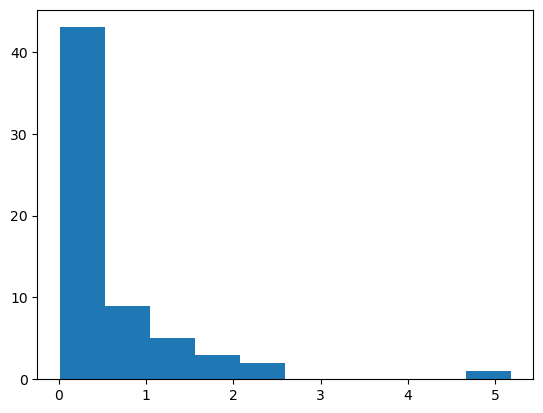

In [11]:
plt.hist(df['z_scores'] )

Filtering for z scores under 3 and removing outliers

In [12]:
df = df[df['z_scores'] < 3].copy()

In [13]:
df = df.drop('z_scores', axis=1)

Let's try some Smoothing, Differencing, Scaling and Normalization

Moving average

In [14]:
moving_avg = df.rolling(window=5).mean()

Differencing

In [15]:
differenced_series = df.diff().dropna()

Scaling

In [16]:
scaler = StandardScaler()
scaled_series = scaler.fit_transform(df.values.reshape(-1, 1))

Let's plot: <br>

A line plot for standard viz <br>
A seasonal plot for seasonal patterns <br>
An autocorrelation plot to check correlation of series with past values <br>

In [17]:
df_monthly = df.resample('ME').mean()

In [18]:
plt.figure(figsize=(15, 18))

<Figure size 1500x1800 with 0 Axes>

<Figure size 1500x1800 with 0 Axes>

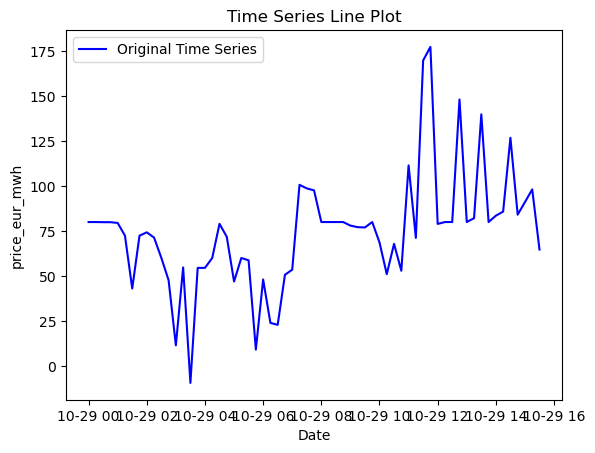

In [19]:
# Line plot
plt.plot(df, label='Original Time Series', color='blue')
plt.title('Time Series Line Plot')
plt.xlabel('Date')
plt.ylabel('price_eur_mwh')
plt.legend()

In [20]:
df.columns

Index(['Imbalance Price'], dtype='object')

Text(0.5, 1.0, 'Autocorrelation Plot')

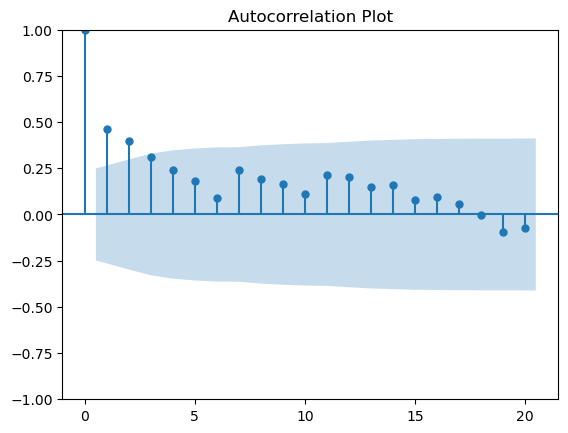

In [21]:
# Autocorrelation plot
plot_acf(df, lags=20, ax=plt.gca())
plt.title('Autocorrelation Plot')

ACF plots correlation of time series with itself at different lags. <br>

A gradual decline suggests a long term dependency in data <br>

Each observation is highly dependant on its recent past values <br>

Non stationarity -> mean and variance likely change overtime (due to trend or seasonality) <br>

Need to difference and account for seasonal/trend component

Text(0.5, 1.0, 'Partial Autocorrelation Plot')

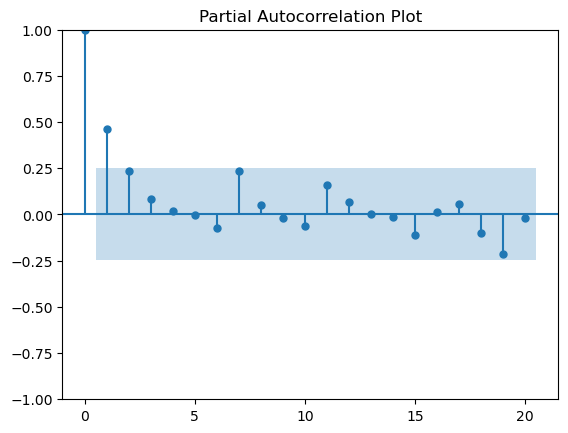

In [22]:
plot_pacf(df, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Plot')

PACF plots correlation between observations at two time points, removing influence of intermediary observations. <br>

Sharp drop after lag 1 suggests one autoregressive term could capture most of the dependency <br>

Correlations insignificant after few lags supports a short memory once first lag is accounted for <br>

ARIMA(1,1,0) after differencing

In [23]:
df.isna().sum()

Imbalance Price    0
dtype: int64

In [34]:
p = 0
d = 0
q = 0

model = ARIMA(df['Imbalance Price'], order=(p, d, q))
model_fit = model.fit()

C:\Users\32472\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\32472\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\32472\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\32472\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\32472\anaconda3\Lib\site-

In [35]:
pred = model_fit.predict(start=1, end=len(df)-1)

In [36]:
y_true = df['Imbalance Price'].iloc[1:]
rmse = np.sqrt(mean_squared_error(y_true, pred))
mae = mean_absolute_error(y_true, pred)

In [37]:
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

RMSE: 32.56
MAE:  21.62


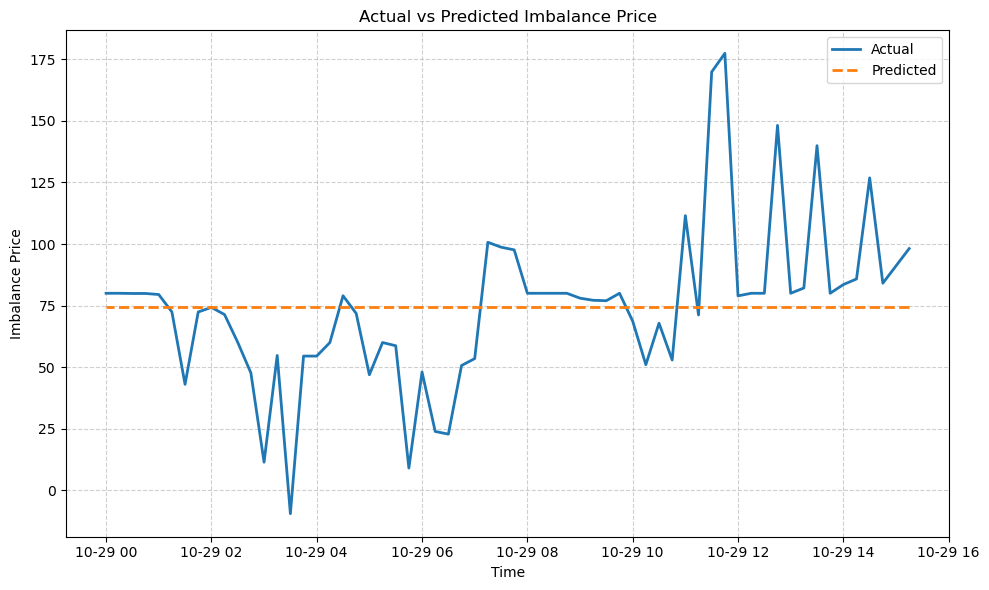

In [38]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_true.index, y_true, label='Actual', linewidth=2)
plt.plot(y_true.index, pred, label='Predicted', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Imbalance Price')
plt.xlabel('Time')
plt.ylabel('Imbalance Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()